In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import random
import glob
import seaborn as sns
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input, GlobalAveragePooling2D, Add, Activation, AveragePooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import ResNet50, Xception, InceptionV3, EfficientNetB4
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

In [24]:
# Mount Google Drive

# Thiết lập đường dẫn
zip_path = r"C:\Users\ORLab\Downloads\New folder\Deepfake_Detection-001.zip"
extract_dir = r"C:\Users\ORLab\Downloads\New folder"
data_dir = r"C:\Users\ORLab\Downloads\New folder"
model_save_dir = r"C:\Users\ORLab\Downloads\New folder\fake_detection_model"

# Tạo thư mục lưu model nếu chưa có
os.makedirs(model_save_dir, exist_ok=True)

# Giải nén file zip nếu cần
if not os.path.exists(os.path.join(data_dir, "Deepfake_Detection")):
    print("Giải nén dữ liệu...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Giải nén hoàn tất!")

# Hàm in cấu trúc thư mục
def print_directory_structure(path, level=0):
    if level <= 3:
        print("    " * level + os.path.basename(path))
        if os.path.isdir(path):
            for item in os.listdir(path):
                item_path = os.path.join(path, item)
                print_directory_structure(item_path, level + 1)

print("Cấu trúc thư mục dữ liệu:")
print_directory_structure(data_dir)

# Tìm tất cả thư mục con có chứa thư mục 'train' hoặc 'test'
dataset_dirs = []
for root, dirs, files in os.walk(data_dir):
    if 'train' in dirs or 'test' in dirs:
        dataset_dirs.append(root)



Giải nén dữ liệu...
Giải nén hoàn tất!
Cấu trúc thư mục dữ liệu:
New folder
    .venv
        .gitignore
        Include
        Lib
            site-packages
        pyvenv.cfg
        Scripts
            activate
            activate.bat
            Activate.ps1
            deactivate.bat
            pip.exe
            pip3.10.exe
            pip3.exe
            python.exe
            pythonw.exe
    Data Set 1
        Data Set 1
            test
            train
            validation
    Data Set 2
        Data Set 2
            test
            train
            validation
    Data Set 3
        Data Set 3
            test
            train
            validation
    Data Set 4
        Data Set 4
            test
            train
            validation
    Deepfake_Detection-001.zip
    Deepfake_Detection_VSCode.ipynb
    fake_detection_model
        logs
            train
            validation
    model
        efficientnetb4_notop.h5
        xception_weights_tf_dim_ordering

In [25]:
# Các tham số cấu hình
img_width, img_height = 224, 224  # Kích thước ảnh đầu vào cho mô hình ResNet và EfficientNet
batch_size = 32
epochs = 50
num_classes = 2  # Real và Fake

In [26]:
# Kiểm tra danh sách dataset
if not dataset_dirs:
    print("❌ Không tìm thấy bất kỳ dataset hợp lệ nào (phải chứa thư mục 'train' hoặc 'test').")
else:
    print(f"✅ Đã tìm thấy {len(dataset_dirs)} bộ dataset:")
    for idx, dataset in enumerate(dataset_dirs):
        print(f"{idx + 1}. {dataset}")

    # Chọn dataset đầu tiên
    selected_dataset = dataset_dirs[0]
    print(f"\n Sử dụng dataset: {selected_dataset}")

# Kiểm tra cấu trúc bộ dataset đã chọn
train_dir = os.path.join(selected_dataset, 'train')
test_dir = os.path.join(selected_dataset, 'test')
val_dir = os.path.join(selected_dataset, 'validation')

# Kiểm tra xem thư mục có tồn tại không
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    print("Lỗi: Không tìm thấy thư mục train hoặc test!")
    # Tìm kiếm cấu trúc thư mục thực tế
    print("Tìm kiếm cấu trúc thư mục thực tế...")
    for root, dirs, files in os.walk(selected_dataset):
        if 'train' in dirs or 'test' in dirs:
            print(f"Tìm thấy thư mục ở: {root}")
            train_dir = os.path.join(root, 'train')
            test_dir = os.path.join(root, 'test')
            if 'validation' in dirs:
                val_dir = os.path.join(root, 'validation')
            break

print(f"Thư mục train: {train_dir}")
print(f"Thư mục test: {test_dir}")
print(f"Thư mục validation: {val_dir}")

# Kiểm tra số lượng ảnh trong từng thư mục
def count_images(directory):
    if not os.path.exists(directory):
        return 0, {}

    class_counts = {}
    total = 0

    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
            total += count

    return total, class_counts

train_count, train_class_counts = count_images(train_dir)
test_count, test_class_counts = count_images(test_dir)
val_count, val_class_counts = count_images(val_dir)

print(f"Số ảnh trong tập train: {train_count}")
for cls, count in train_class_counts.items():
    print(f"  - {cls}: {count} ảnh")

print(f"Số ảnh trong tập test: {test_count}")
for cls, count in test_class_counts.items():
    print(f"  - {cls}: {count} ảnh")

print(f"Số ảnh trong tập validation: {val_count}")
for cls, count in val_class_counts.items():
    print(f"  - {cls}: {count} ảnh")

✅ Đã tìm thấy 17 bộ dataset:
1. C:\Users\ORLab\Downloads\New folder\Data Set 1\Data Set 1
2. C:\Users\ORLab\Downloads\New folder\Data Set 2\Data Set 2
3. C:\Users\ORLab\Downloads\New folder\Data Set 3\Data Set 3
4. C:\Users\ORLab\Downloads\New folder\Data Set 4\Data Set 4
5. C:\Users\ORLab\Downloads\New folder\fake_detection_model\logs
6. C:\Users\ORLab\Downloads\New folder\tf\Lib\site-packages\tensorflow\python\compiler\tensorrt
7. C:\Users\ORLab\Downloads\New folder\tf\Lib\site-packages\tensorflow\_api\v2
8. C:\Users\ORLab\Downloads\New folder\tf\Lib\site-packages\tensorflow\_api\v2\compat\v1
9. C:\Users\ORLab\Downloads\New folder\tf\Lib\site-packages\tensorflow\_api\v2\compat\v2
10. C:\Users\ORLab\Downloads\New folder\tf\Lib\site-packages\tensorflow\_api\v2\compat\v2\__internal__
11. C:\Users\ORLab\Downloads\New folder\tf\Lib\site-packages\tensorflow\_api\v2\__internal__
12. C:\Users\ORLab\Downloads\New folder\tf-gpu\Lib\site-packages\tensorflow\python\compiler\tensorrt
13. C:\Users

Hiển thị một số ảnh mẫu từ tập train:


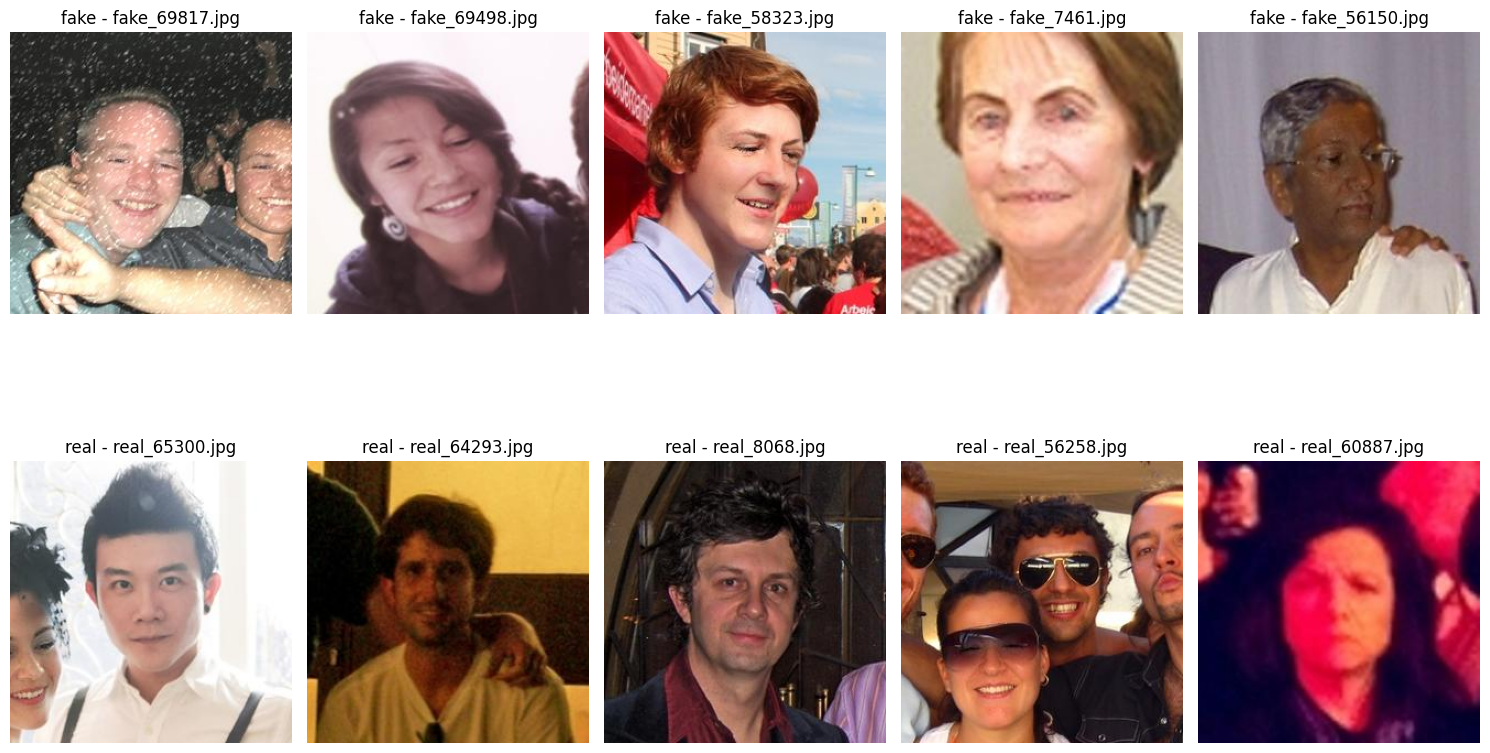

In [27]:
# Hiển thị một số ảnh mẫu
def show_sample_images(directory, num_samples=5):
    plt.figure(figsize=(15, 10))
    class_names = os.listdir(directory)

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                      if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if images:
                samples = random.sample(images, min(num_samples, len(images)))

                for j, img_path in enumerate(samples):
                    plt.subplot(len(class_names), num_samples, i*num_samples + j + 1)
                    img = plt.imread(img_path)
                    plt.imshow(img)
                    plt.title(f"{class_name} - {os.path.basename(img_path)}")
                    plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Hiển thị một số ảnh mẫu từ tập train:")
show_sample_images(train_dir)

In [28]:
# Chuẩn bị dữ liệu với Data Augmentation cho tập train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Chỉ rescale cho tập validation và test
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu
print("Đang load dữ liệu...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

if os.path.exists(val_dir):
    validation_generator = valid_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
else:
    validation_generator = None

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Đang load dữ liệu...
Found 40002 images belonging to 2 classes.
Found 12360 images belonging to 2 classes.
Found 5227 images belonging to 2 classes.
Class indices: {'fake': 0, 'real': 1}


Hiển thị một batch ảnh đã qua augmentation:


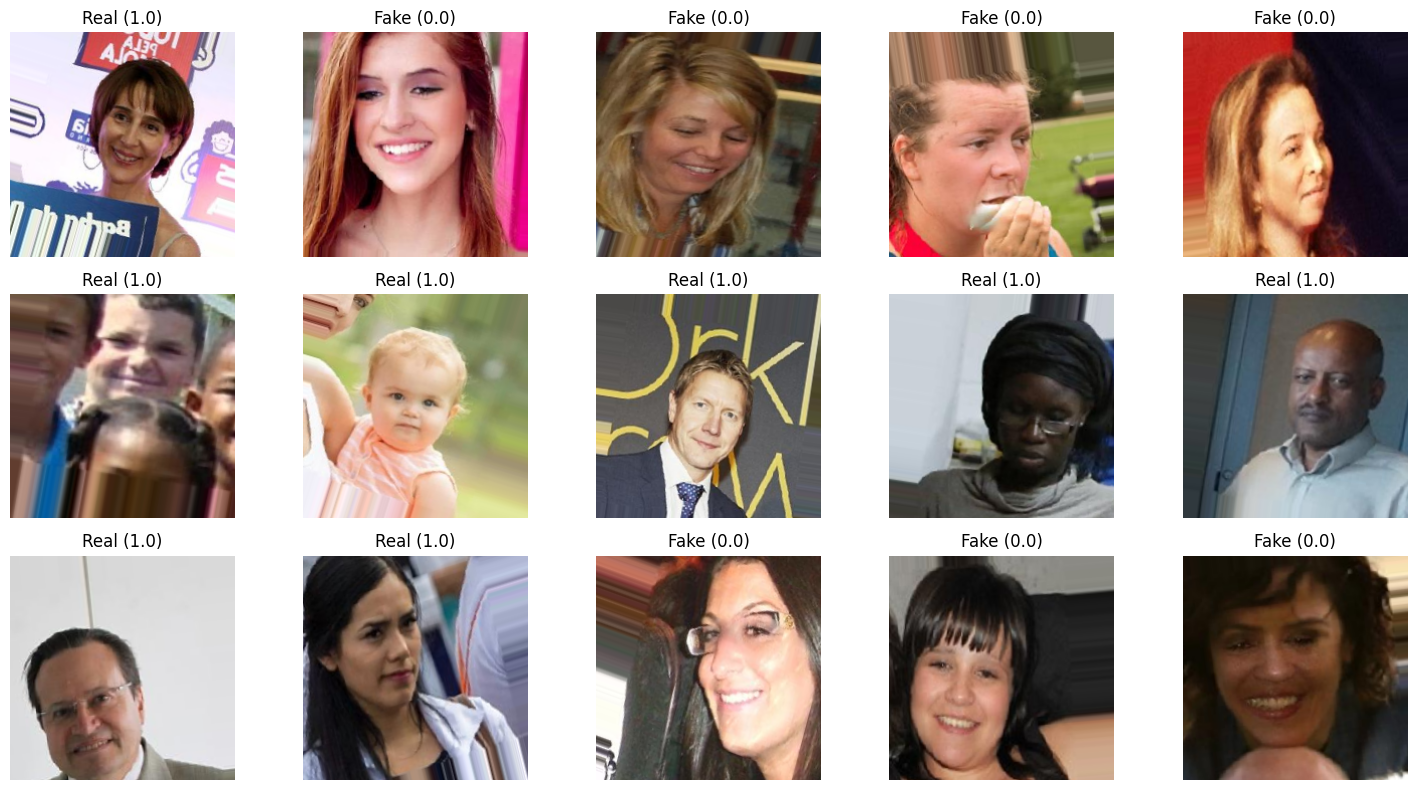

In [29]:
# Hiển thị một batch ảnh đã augmented
def show_augmented_batch(generator):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(15, 8))

    for i in range(min(15, len(x_batch))):
        plt.subplot(3, 5, i+1)
        plt.imshow(x_batch[i])
        class_name = 'Fake' if y_batch[i] == 0 else 'Real'
        plt.title(f"{class_name} ({y_batch[i]})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Hiển thị một batch ảnh đã qua augmentation:")
show_augmented_batch(train_generator)

In [30]:
# Xây dựng mô hình CNN từ đầu
def build_custom_cnn():
    model = Sequential([
        # Block 1
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 4
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 5
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully connected layers
        Flatten(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (Real/Fake)
    ])

    # Compile model with Adam optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [31]:
# Transfer Learning với EfficientNetB4
def build_efficientnet_model():
    # Tải mô hình EfficientNetB4 không bao gồm lớp fully connected
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    # Đóng băng các lớp trong base model
    for layer in base_model.layers:
        layer.trainable = False

    # Xây dựng mô hình hoàn chỉnh
    inputs = Input(shape=(img_width, img_height, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [32]:
# Xây dựng mô hình ensemble (kết hợp)
def build_ensemble_model():
    # Tạo 2 đường dẫn khác nhau
    # Đường dẫn 1: EfficientNetB4
    input_shape = (img_width, img_height, 3)
    inputs = Input(shape=input_shape)

    # Đường dẫn EfficientNet
    base_model1 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model1.layers:
        layer.trainable = False
    x1 = base_model1(inputs)
    x1 = GlobalAveragePooling2D()(x1)
    x1 = Dropout(0.4)(x1)
    x1 = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x1)

    # Đường dẫn Xception
    base_model2 = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model2.layers:
        layer.trainable = False
    x2 = base_model2(inputs)
    x2 = GlobalAveragePooling2D()(x2)
    x2 = Dropout(0.4)(x2)
    x2 = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x2)

    # Kết hợp hai đường dẫn
    combined = concatenate([x1, x2])
    combined = Dropout(0.5)(combined)
    combined = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined = BatchNormalization()(combined)
    combined = Dropout(0.3)(combined)
    outputs = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [ ]:
# Chọn model (Dùng ensemble để có mô hình mạnh nhất)
model = build_ensemble_model()
model.summary()

# Tạo callbacks
checkpoint = ModelCheckpoint(
    os.path.join(model_save_dir, 'fake_detection_best.keras'),
    monitor='val_accuracy' if validation_generator else 'accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss' if validation_generator else 'loss',
    patience=15,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss' if validation_generator else 'loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir=os.path.join(model_save_dir, 'logs'),
    histogram_freq=1
)

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb4 (Functional)    (None, 7, 7, 1792)   17673823    ['input_10[0][0]']               
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_10[0][0]']               
                                                                                                  
 global_average_pooling2d_6 (Gl  (None, 1792)        0           ['efficientnetb4[0][0]']   

In [34]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [35]:
# Huấn luyện mô hình
print("Huấn luyện mô hình...")
validation_data = validation_generator if validation_generator else test_generator

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_data,
    callbacks=callbacks,
    verbose=1
)

Huấn luyện mô hình...
Epoch 1/50
  79/1251 [>.............................] - ETA: 6:59 - loss: 3.1697 - accuracy: 0.5332 - auc_3: 0.5530 - precision_3: 0.5312 - recall_3: 0.5219

KeyboardInterrupt: 

In [ ]:
# Vẽ biểu đồ huấn luyện
def plot_training_history(history):
    metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(15, 15))

    for i, metric in enumerate(metrics):
        if metric in history.history:
            plt.subplot(3, 2, i+1)
            plt.plot(history.history[metric])
            plt.plot(history.history[f'val_{metric}'])
            plt.title(f'Model {metric}')
            plt.ylabel(metric.capitalize())
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='best')

    plt.tight_layout()
    plt.savefig(os.path.join(model_save_dir, 'training_history.png'))
    plt.show()

    # Lưu lịch sử huấn luyện thành file CSV
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = os.path.join(model_save_dir, 'training_history.csv')
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

plot_training_history(history)

In [ ]:
# Đánh giá mô hình trên tập test
print("Đánh giá mô hình trên tập test...")
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(test_generator)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

# Tính F1 Score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-10)
print(f'Test F1 Score: {f1_score:.4f}')


In [ ]:
# Dự đoán trên tập test
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = test_generator.classes

# In báo cáo phân loại
print("Classification Report:")
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

In [ ]:
# Lưu kết quả vào file
with open(os.path.join(model_save_dir, 'classification_report.txt'), 'w') as f:
    f.write(f'Test loss: {test_loss:.4f}\n')
    f.write(f'Test accuracy: {test_accuracy:.4f}\n')
    f.write(f'Test AUC: {test_auc:.4f}\n')
    f.write(f'Test precision: {test_precision:.4f}\n')
    f.write(f'Test recall: {test_recall:.4f}\n')
    f.write(f'Test F1 Score: {f1_score:.4f}\n\n')
    f.write("Classification Report:\n")
    f.write(report)

In [ ]:
# Vẽ ma trận nhầm lẫn
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(model_save_dir, 'confusion_matrix.png'))
    plt.show()

plot_confusion_matrix(y_true, y_pred, class_names)


In [ ]:
# Vẽ đường cong ROC
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(model_save_dir, 'roc_curve.png'))
    plt.show()

    return roc_auc

roc_auc = plot_roc_curve(y_true, y_pred_prob)
print(f'ROC AUC: {roc_auc:.4f}')

In [ ]:
# Vẽ đường cong Precision-Recall
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    average_precision = average_precision_score(y_true, y_pred_prob)

    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.4f})')
    plt.axhline(y=sum(y_true)/len(y_true), color='red', linestyle='--', label=f'Baseline (prevalence = {sum(y_true)/len(y_true):.4f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(model_save_dir, 'precision_recall_curve.png'))
    plt.show()

    return average_precision

ap = plot_precision_recall_curve(y_true, y_pred_prob)
print(f'Average Precision: {ap:.4f}')


In [ ]:
# Lưu mô hình
model_path = os.path.join(model_save_dir, 'fake_detection_model.h5')
model.save(model_path)
print(f"Model đã được lưu tại: {model_path}")

In [ ]:
# Hàm dự đoán ảnh thật/giả từ một ảnh bất kỳ
def predict_image(model, image_path):
    from tensorflow.keras.preprocessing import image

    # Load và tiền xử lý ảnh
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Chuẩn hóa

    # Dự đoán
    prediction = model.predict(img_array)[0][0]

    # Phân loại
    label = "Real" if prediction > 0.5 else "Fake"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    # Hiển thị kết quả
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Predicted: {label} ({confidence:.4f})')
    plt.axis('off')

    result_path = os.path.join(model_save_dir, f'prediction_{os.path.basename(image_path)}')
    plt.savefig(result_path)
    plt.show()

    return label, confidence

In [ ]:
# Dự đoán một số ảnh mẫu từ tập test
def test_sample_images(test_generator, model, num_samples=5):
    filenames = test_generator.filenames
    class_indices = test_generator.class_indices
    indices_to_class = {v: k for k, v in class_indices.items()}

    # Lấy ngẫu nhiên một số ảnh
    sample_indices = random.sample(range(len(filenames)), min(num_samples, len(filenames)))

    for idx in sample_indices:
        img_path = os.path.join(test_generator.directory, filenames[idx])
        true_class = indices_to_class[test_generator.classes[idx]]

        predicted_class, confidence = predict_image(model, img_path)

        print(f"Ảnh: {filenames[idx]}")
        print(f"Thực tế: {true_class}")
        print(f"Dự đoán: {predicted_class}")
        print(f"Độ tin cậy: {confidence:.4f}")
        print("-----------------------------------")

print("Thực hiện dự đoán trên một số ảnh mẫu...")
test_sample_images(test_generator, model, num_samples=10)

In [ ]:
# Tạo mô hình có khả năng fine-tuned cho hiệu suất tốt hơn
def create_fine_tuned_model():
    # Bắt đầu với mô hình đã được huấn luyện
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    # Mở khóa một số lớp cuối cùng để fine-tune
    for layer in base_model.layers[-30:]:  # Mở khóa 30 lớp cuối
        layer.trainable = True

    # Xây dựng mô hình hoàn chỉnh
    inputs = Input(shape=(img_width, img_height, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    fine_tuned_model = Model(inputs=inputs, outputs=outputs)

    # Compile với learning rate thấp hơn để fine-tune
    fine_tuned_model.compile(
        optimizer=Adam(learning_rate=0.00001),  # Learning rate thấp hơn
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return fine_tuned_model

print("Đang tạo mô hình fine-tuned...")
fine_tuned_model = create_fine_tuned_model()